In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

# Загрузка данных
data = pd.read_csv('cleaned_data.csv')

# Удаление ненужных столбцов
data = data.drop('Unnamed: 0', axis=1)

# Создание бинарных целевых переменных на основе медианных значений
median_ic50 = data['IC50, mM'].median()


data['IC50_above_median'] = (data['IC50, mM'] > median_ic50).astype(int)

# Разделение на признаки и целевые переменные
features = data.drop(['IC50, mM', 'CC50, mM', 'SI', 
                     'IC50_above_median'], axis=1)
targets = data[['IC50_above_median']]

# Масштабирование признаков
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, targets, test_size=0.2, random_state=42)

# Функция для обучения и оценки моделей
def train_and_evaluate_models(X_train, X_test, y_train, y_test, target_name):
    print(f"\n=== Модели для классификации: {target_name} ===")
    
    # Инициализация моделей
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
        'LightGBM': LGBMClassifier(random_state=42),
        'SVM': SVC(probability=True, random_state=42)
    }
    
    best_model = None
    best_score = 0
    results = {}
    
    for name, model in models.items():
        print(f"\nОбучение модели: {name}")
        
        # Обучение модели
        model.fit(X_train, y_train[target_name])
        
        # Предсказания
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        
        # Оценка качества
        print(classification_report(y_test[target_name], y_pred))
        roc_auc = roc_auc_score(y_test[target_name], y_proba)
        print(f"ROC-AUC: {roc_auc:.4f}")
        
        # Сохранение результатов
        results[name] = {
            'classification_report': classification_report(y_test[target_name], y_pred, output_dict=True),
            'roc_auc': roc_auc
        }
        
        # Проверка на лучшую модель
        if roc_auc > best_score:
            best_score = roc_auc
            best_model = name
    
    print(f"\nЛучшая модель для {target_name}: {best_model} с ROC-AUC = {best_score:.4f}")
    return results, best_model

# Обучение моделей для каждой целевой переменной
ic50_results, ic50_best = train_and_evaluate_models(X_train, X_test, y_train, y_test, 'IC50_above_median')

# Оптимизация гиперпараметров для лучших моделей
def optimize_best_model(model_name, X_train, y_train):
    if model_name == 'Gradient Boosting':
        param_grid = {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5]
        }
        model = GradientBoostingClassifier(random_state=42)
    elif model_name == 'XGBoost':
        param_grid = {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5],
            'subsample': [0.8, 1.0]
        }
        model = XGBClassifier(random_state=42, eval_metric='logloss')
    elif model_name == 'LightGBM':
        param_grid = {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'num_leaves': [31, 50],
            'max_depth': [-1, 5]
        }
        model = LGBMClassifier(random_state=42)
    else:
        return None
    
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print(f"\nЛучшие параметры для {model_name}:")
    print(grid_search.best_params_)
    print(f"Лучший ROC-AUC: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_

# Оптимизация для каждой задачи
best_ic50_model = optimize_best_model(ic50_best, X_train, y_train['IC50_above_median'])


=== Модели для классификации: IC50_above_median ===

Обучение модели: Logistic Regression
              precision    recall  f1-score   support

           0       0.70      0.69      0.69        97
           1       0.71      0.72      0.72       104

    accuracy                           0.71       201
   macro avg       0.71      0.71      0.71       201
weighted avg       0.71      0.71      0.71       201

ROC-AUC: 0.7549

Обучение модели: Gradient Boosting
              precision    recall  f1-score   support

           0       0.70      0.73      0.72        97
           1       0.74      0.71      0.73       104

    accuracy                           0.72       201
   macro avg       0.72      0.72      0.72       201
weighted avg       0.72      0.72      0.72       201

ROC-AUC: 0.7965

Обучение модели: XGBoost
              precision    recall  f1-score   support

           0       0.69      0.74      0.71        97
           1       0.74      0.68      0.71       10


Анализ медианного значения IC50, mM:
Медианное значение IC50, mM: 46.5852
Количество соединений с IC50, mM > медианы: 500 из 1001
Доля соединений с IC50, mM > медианы: 49.95%



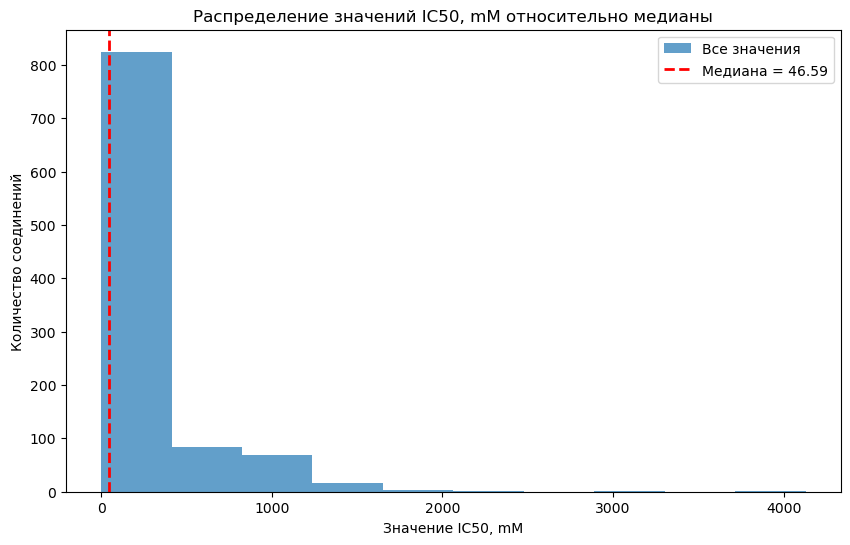

In [21]:
import matplotlib.pyplot as plt

print("\n" + "="*50)
print("Анализ медианного значения IC50, mM:")
print(f"Медианное значение IC50, mM: {median_ic50:.4f}")
print(f"Количество соединений с IC50, mM > медианы: {data['IC50_above_median'].sum()} из {len(data)}")
print(f"Доля соединений с IC50, mM > медианы: {data['IC50_above_median'].mean():.2%}")
print("="*50 + "\n")



plt.figure(figsize=(10, 6))
plt.hist(data['IC50, mM'], bins=10, alpha=0.7, label='Все значения')
plt.axvline(median_ic50, color='red', linestyle='dashed', linewidth=2, label=f'Медиана = {median_ic50:.2f}')
plt.title('Распределение значений IC50, mM относительно медианы')
plt.xlabel('Значение IC50, mM')
plt.ylabel('Количество соединений')
plt.legend()
plt.show()